In [307]:
#!pip install --upgrade threadpoolctl 
import warnings
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import datetime
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import plotly.express as px
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import pandas as pd
import plotly.express as px
import dash_html_components as html
import re

warnings.filterwarnings('ignore')

In [308]:
# Load the dataset from a CSV file
data = pd.read_csv('2009_2020CrimeData_2319764293480411244.csv')
pd.set_option('display.max_columns', None)
data.head(5)

,IDCol,Report Number,Report Date,Day Occurred,Day Number,Occur Date,Occur Time,Possible Date,Possible Time,Beat,Zone,Location,Apartment Number,Crime Type,NIBRS Code,Neighborhood,NPU,Longitude,Latitude,ObjectId,x,y
0,320197,203581105,12/23/2020 12:00:00 AM,Wednesday,4,12/23/2020,10:00,12/23/2020,16:45,410,4,2400 CAMPBELLTON RD SW,NaN,BURGLARY,220,Campbellton Road,R,-84.466012,33.702732,1,-9.402713e+06,3.988956e+06
1,320198,203581144,12/23/2020 12:00:00 AM,Wednesday,4,12/23/2020,17:16,12/23/2020,17:30,505,5,736 W PEACHTREE ST NW,NaN,LARCENY-FROM VEHICLE,23F,Midtown,E,-84.387771,33.774764,2,-9.394004e+06,3.998598e+06
2,320199,203581174,12/23/2020 12:00:00 AM,Saturday,7,12/19/2020,21:50,12/19/2020,22:30,211,2,2399 PIEDMONT RD NE,NaN,LARCENY-FROM VEHICLE,23F,Lindbergh/Morosgo,B,-84.366938,33.819892,3,-9.391685e+06,4.004643e+06
3,320200,203581238,12/23/2020 12:00:00 AM,Wednesday,4,12/23/2020,18:05,12/23/2020,18:09,206,2,339 BUCKHEAD AVE NE,NaN,AUTO THEFT,240,Buckhead Village,B,-84.376506,33.837935,4,-9.392750e+06,4.007061e+06
4,320201,203581247,12/23/2020 12:00:00 AM,Wednesday,4,12/23/2020,18:12,NaN,NaN,204,2,1801 HOWELL MILL RD NW,NaN,LARCENY-NON VEHICLE,23C,Berkeley Park,D,-84.412846,33.804230,5,-9.396795e+06,4.002545e+06


#### Data Preprocessing

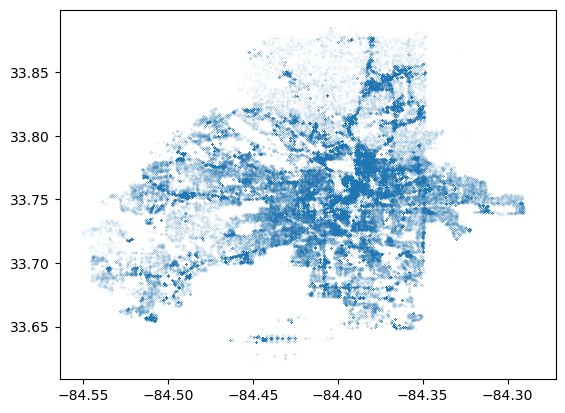

In [309]:
# Drop out 4-5 geographic outliers
data = data.drop(data[data.Latitude < 33.5].index)

# Clean up date column
data['Occur Date'] = data['Occur Date'].replace('1010-10-30','10/30/2010')
data['Occur Date'] = data['Occur Date'].replace('0220-11-01','11/01/2020')
data['Occur Date'] = data['Occur Date'].replace('1/1/1993','3/12/2010')
data['Occur Date'] = pd.to_datetime(data['Occur Date'])

# Define a column of the month of the crime
data['MonthYear'] = data['Occur Date'].dt.strftime('%Y-%m')

# Filter out temporal outlier data
data = data[data['Occur Date'].dt.year >= 2009]

# Extract latitude and longitude columns
X = data[['Latitude', 'Longitude']]


# Plot the crime locations
plt.scatter(X.Longitude, X.Latitude, s = 0.0008)


#### Clustering 

In [310]:
# Choose the number of clusters (K)
k = 30

# Create a GMM instance with the desired number of clusters
gmm = GaussianMixture(n_components=k, random_state= 42)

# Fit the K-means model to the standardized data
data['Cluster'] = gmm.fit_predict(X)


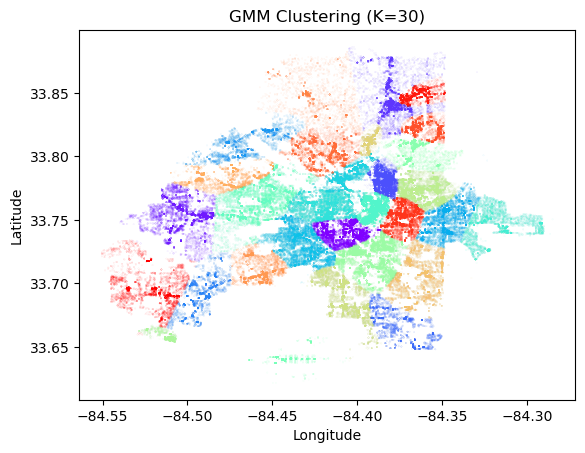

In [311]:
# Visualize the results
plt.scatter(X['Longitude'], X['Latitude'], c=data['Cluster'], cmap='rainbow', s = 0.0008)
plt.title(f'GMM Clustering (K={k})')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

#### Crime Rating Assignment based on severity of crime

We have used the following scales for the 7 crime types   
    'AGG ASSAULT': 4,
    'AUTO THEFT': 3,
    'BURGLARY': 3,
    'HOMICIDE': 5,
    'LARCENY-FROM VEHICLE': 2,
    'LARCENY-NON VEHICLE': 2,
    'ROBBERY': 3
The severity of these are from 5 to 1 for 5 being most severe. These score are only illustratiev, however these scores can be changed based on the general sentiment or an official score can be introduced.The scores have then been aggregated for each month for each cluster into a crime rating score

In [365]:
## HOTSPOTWISE MONTHLY CRIME RATINGS ##

# Cross tabulate the clusters and months with the crime type counts
tab = pd.crosstab([data.Cluster, data.MonthYear],data['Crime Type'])
coefs = {
    'AGG ASSAULT': 4,
    'AUTO THEFT': 3,
    'BURGLARY': 3,
    'HOMICIDE': 5,
    'LARCENY-FROM VEHICLE': 2,
    'LARCENY-NON VEHICLE': 2,
    'ROBBERY': 3
}

# Normalize the coefficients to sum to 1
total = sum(coefs.values())
for i in coefs:
    coefs[i] = coefs[i] / total

# Linear combination helper function to calculate crime rating
def linear_combination(row):
    return sum(row[crime_type] * coefficient for crime_type, coefficient in coefs.items())

# Add daysinmonth column to normalize crime rating
tab['MonthYear'] = pd.to_datetime(tab.index.get_level_values('MonthYear'))
tab['DaysInMonth'] = tab['MonthYear'].dt.daysinmonth

# Calculate the rating based on weigtages and normalize it by the number of days in each month
tab['CrimeRating'] = tab.apply(linear_combination, axis=1)
tab['CrimeRating'] = tab['CrimeRating'] / tab['DaysInMonth']
tab = tab.drop('DaysInMonth', axis=1)

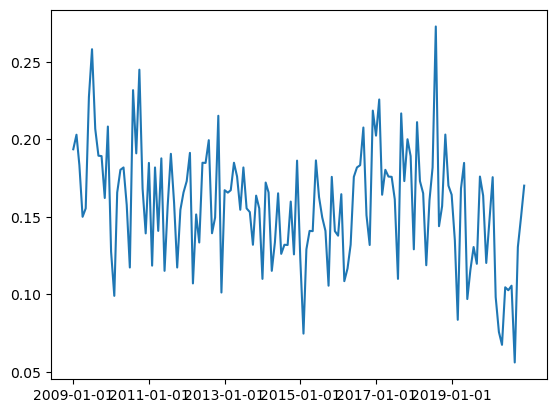

In [366]:
# Plot data of a given hotspot
def plot_hotspot(tab, hotspot_index):
    cdata = tab.loc[hotspot_index]
    plt.plot(cdata.MonthYear,cdata.CrimeRating)
    plt.xticks(cdata['MonthYear'][::24])
    plt.show()

plot_hotspot(tab, 15)

#### Crime Rating prediction for Single cluster

We have used time series modelling using exponential smoothing for predicting the risk scores/crime ratings for each cluster. We have used the last 24 months(2019,2020) as testing data and the rest(2009 - 2018) as training data for our model . We have used an exponential smoothing model with both seasonality and trend. Seasonality is taken as 1 year. 

In [367]:
# Train and predict time series model on hotspot data
def timeSeries(tab, hotspot_index, testlen):
    crating = tab.loc[hotspot_index].CrimeRating
    train = crating.iloc[:-testlen, ]
    test = crating.iloc[-testlen:,]
    model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12, damped = True)
    model = model.fit()
    pred = model.forecast(testlen)
    sse = np.sqrt(np.mean(np.square(test.values - pred.values)))
    mask = test.values != 0
    mape_score = (np.abs((test.values - pred.values) / test.values)[mask].mean())
    aic = model.aic
    
    return train, test, pred, sse, mape_score, aic, model


In [368]:
#### predict for a single cluster 
train, test, pred, sse, mape, aic, model = timeSeries(tab, 26, 24)
train = train[-48:]

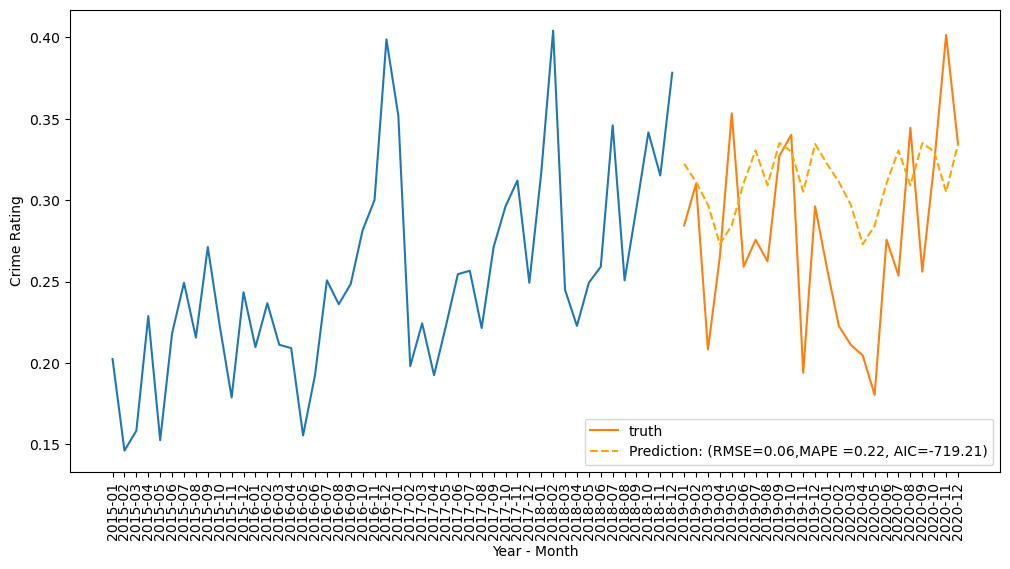

In [369]:
##### plot the predictions for the cluster
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index, train.values);
ax.plot(test.index, test.values, label='truth');
ax.plot(test.index, pred, linestyle='--', color='orange', label="Prediction: (RMSE={:0.2f},MAPE ={:0.2f}, AIC={:0.2f})".format(sse,mape, aic))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel('Crime Rating')
ax.set_xlabel('Year - Month')
ax.legend()

#### Predicting CrimeRating for all clusters

In [319]:
#predict for all the clusters
outputdata = []
for i in range(30):
    outputdata.append(timeSeries(tab,i,24))

#### Getting Overall Metrics for the predictions

In [325]:
sse_values = [item[3] for item in outputdata]
mape_values = [item[4] for item in outputdata]
print(f"The average MAPE score over all clusters for the test dataset is {np.mean(mape_values)}")
print(f"The average SSE score over all clusters for the test dataset is {np.mean(sse_values)}")

The average MAPE score over all clusters for the test dataset is 0.3389498776060368
The average SSE score over all clusters for the test dataset is 0.06629097351115604


The average MAPE score for all the clusters combined is 33.89% and the average SSE is 0.0662

#### Aggregating all the data including predictions into a single dataframe

In [321]:
#### get predictions 
preds = [item[2] for item in outputdata]
##### Make the predictions to same format
concat_series = pd.concat(preds, axis=0)

df = pd.DataFrame(concat_series)
df = df.reset_index()

df.columns = ["MonthYear", "CrimeRatePreds"]

group_size = 24
df['Cluster'] = (df.index // group_size).astype(int)

df['MonthYear'] = pd.to_datetime(df['MonthYear'])

# Extract the year and month as a Period
df['MonthYear'] = df['MonthYear'].dt.to_period('M')

# If you want to keep it as a string with the 'YYYY-MM' format
df['MonthYear'] = df['MonthYear'].astype(str)

tab = tab.drop(columns='MonthYear').reset_index()
###### Merge all the data including predictions here
final_df = pd.DataFrame({'Cluster': tab["Cluster"], 'MonthYear': tab['MonthYear'], 'AGG ASSAULT': tab['AGG ASSAULT'], 'AUTO THEFT': tab['AUTO THEFT'], 'BURGLARY': tab['BURGLARY'], 'HOMICIDE': tab['HOMICIDE'],'LARCENY-FROM VEHICLE': tab['LARCENY-FROM VEHICLE'],'LARCENY-NON VEHICLE': tab['LARCENY-NON VEHICLE'],'ROBBERY': tab['ROBBERY'],'CrimeRating': tab['CrimeRating']})

merged_df = pd.merge(data[['Latitude', 'Longitude','Cluster','MonthYear']], final_df, on=['Cluster','MonthYear'], how='left')

merged_df = pd.merge(merged_df, df, on=['Cluster','MonthYear'], how='left')

In [322]:
app = dash.Dash(__name__)
# Create options for the dropdown menu
month_year_options = [{'label': month_year, 'value': month_year} for month_year in sorted(merged_df['MonthYear'].unique())]

# Layout of the app
app.layout = html.Div([
    html.H1("Crime Visualization"),
    
    # Dropdown for selecting MonthYear
    dcc.Dropdown(
        id='month-year-dropdown',
        options=month_year_options,
        value=merged_df['MonthYear'].unique()[0],  # Set initial value to the first MonthYear
        multi=False
    ),
    
    # Map to display crime clusters
    dcc.Graph(id='crime-map'),
    
    # Bar chart to display crime information
    html.Div([
        dcc.Graph(id='crime-bar-chart', style={'height': '400px', 'width': '80%'})  # Adjust height and width as needed
    ], style={'margin': 'auto'})
])

# Callbacks to update the map and bar chart based on the selected MonthYear
@app.callback(
    Output('crime-bar-chart', 'figure'),
    [Input('crime-map', 'hoverData'),
     Input('month-year-dropdown', 'value')]
)
def update_figures(hover_data, selected_month_year):

    
    if hover_data is None:
        # If no cluster is hovered over, display an empty bar chart
        bar_chart_fig = px.bar()

    else:
        # Extract the hovered cluster from the hover data
        hovered_cluster_str = hover_data['points'][0]['hovertext']
        hovered_cluster = int(re.findall(r'\d+', hovered_cluster_str)[0])
        # Filter the DataFrame based on the hovered cluster and selected MonthYear
        filtered_df_cluster = merged_df[(merged_df['Cluster'] == hovered_cluster) & (merged_df['MonthYear'] == selected_month_year)]
        filtered_df_cluster = filtered_df_cluster[['MonthYear', 'AGG ASSAULT', 'AUTO THEFT', 
                                    'BURGLARY', 'HOMICIDE', 'LARCENY-FROM VEHICLE', 
                                    'LARCENY-NON VEHICLE', 'ROBBERY','Cluster']].drop_duplicates()
        counts = filtered_df_cluster[['AGG ASSAULT', 'AUTO THEFT', 'BURGLARY', 'HOMICIDE', 'LARCENY-FROM VEHICLE', 'LARCENY-NON VEHICLE', 'ROBBERY']].sum()

        bar_chart_fig = px.bar(
            x=counts.values,
            y=counts.index,
            orientation='h',  # Set the orientation to horizontal
            title=f'Crime Information for Cluster {hovered_cluster} - MonthYear {selected_month_year}',
            labels={'x': 'Count', 'y': 'Crime Type'},
            color_discrete_sequence=px.colors.qualitative.Set3  # Change to a different color scale if needed
        )

        # Update layout of the bar chart for better readability
        bar_chart_fig.update_layout(
            margin=dict(l=0, r=0, t=50, b=0)  # Adjust margins
        )

    return bar_chart_fig

@app.callback(
    Output('crime-map', 'figure'),
    [Input('month-year-dropdown', 'value')]
)
def update_map(selected_month_year):
    # Filter the DataFrame based on the selected MonthYear
    filtered_df = merged_df[merged_df['MonthYear'] == selected_month_year]
    filtered_df['HoverName'] = filtered_df['Cluster'].apply(lambda x: f"Cluster: {x}")


    # Create map figure
    map_fig = px.scatter_mapbox(
        filtered_df,
        lat="Latitude",
        lon="Longitude",
        color="CrimeRating",
        hover_name="HoverName",
        hover_data={"CrimeRating", "CrimeRatePreds"},
        mapbox_style="carto-positron",
        zoom=10,
    )
    
    return map_fig


There is not a lot of variation monthwise in the clusters, however we can see the neighborhood with the hist risk score/crime rating are the ones in the vicinity of Five Points and Hotel District. The areas with the least crime rating include Carey Park, Kirkwood, East Lake Highlands and places a bit far away from the Atlanta City center. It is safe to assume that most of the crimes that happen are in the Atlanta city center in places like Home Park/Atlantic Statio, Midtown etc. We can also see from the barchart that Vehicular larceny and auto theft are the most popular crime in these regions. Thus there should be more policing  for these crime types in this region. We can also observe a general reduction in the crime ratings as well over the years. 

In [323]:

if __name__ == '__main__':
    app.run_server(host='127.0.0.1', port=8050, debug=False)